# Are You Good Enough to Make the kNN Algorithm Work?
## Learn what it takes to master it
<img src='images/neigh.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@suju?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Susanne Jutzeler</a>
        on 
        <a href='https://www.pexels.com/photo/closed-doors-3015714/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### What Is KNN?

> Raise your hand if kNN is the first algorithm you were introduced in a machine learning course ✋🤚

*k* Nearest Neighbors algorithm is one of the most commonly used algorithms in machine learning. Because of its simplicity, many beginners often start their wonderful journey of ML with this algorithm. It is one of the few algorithms which can smoothly be used both for regression and classification.

So, what makes kNN so versatile and easy at the same time? The answer is hidden in how it works under the hood.

Imagine you have a variable with 2 categories which are visualized here:

<img src='images/wiki_image.png'></img>

Given a new, unknown sample, how do you tell which group it belongs to? Well, naturally, you would look at the surrounding points. But the result would be really dependent on how far you look. If you just look at the closest 3, (solid circle) the green dot would belong to red triangles. If you look further, (dashed circle) dot would be classified as blue square. 

kNN works the same way. Depending on the value of *k*, algorithm classifies new samples by the majority vote of the nearest *k* neighbors in classification. For regression which predicts actual numerical value of a new sample, the algorithm just takes the mean of the nearest *k* neighbors. That's it. As easy as that.

However, using the algorithm in code and successfully generating predictions is not that simple. Today, we will look at the nitty-gritty details of how the algorithm works, how to prepare any data so that it aligns with the algorithms internals and how to significantly improve its performance (from 80% to 95% in this notebook).

### k-Nearest-Neighbors, under the hood

The first thing you should know about the internals of kNN is that it is a lazy algorithm. In machine learning lingo, it means the algorithm has no or extremely short training phase compared to others. Don't get your hopes up yet because speedy training comes with a big drawback.

Generating predictions will be much slower because of how kNN finds the nearest neighbors. In the short training phase, it memorizes all data points. To make a prediction, the algorithm finds the distance between the new sample and every single data point in the dataset. Then, it takes the *k* smallest distances and classifies the new sample depending on the majority of the vote of its neighbors.
<img src='images/1.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Image by 
        <a href='https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm'>Wikipedia</a>
    </strong>
</figcaption>

To the human eye, labeling the green dot is no problem at all. But, there is no way for the algorithm to find the nearest neighbors without calculating the distance between every single point. 

The distance itself is calculated using one of 3 distance metrics:
- Euclidean distance: the square root of sum of differences between the components of x and y:
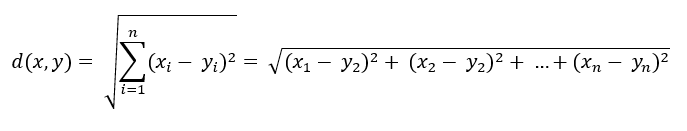
- Manhattan distance: the sum of the absolute values of differences between the components of x and y coordinates:
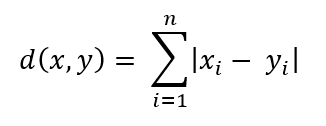
- Minkowski distance is the generalization of the above two techniques. It has a parameter *p* that takes a value of either 1 or 2. When *p=1*, formula becomes manhattan distance, and *p=2* for euclidean:
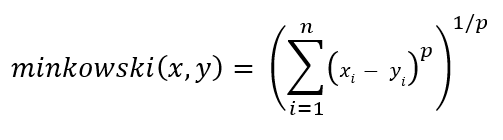

Sorry for the fancy formulas, but you might as well get used to it if you are going to learn machine learning further on.

> The lack of training phase also means that the algorithm does not *generalize*.

Next, kNN is also a *non-parametric* algorithm - it does not have strict requirements on the shape and distribution of your data. Unlike linear regression, which assumes your features and target have a linear relationship, kNN makes no such assumptions. That's why it is considered as one of the easiest models out there and works pretty well out-of-the-box if trained on 'appropriate' data. (And I explain what I mean by 'appropriate' in a later section)

### How to Choose the Value of *k*

I think you have already realized that the results of the algorithm entirely depends on the value of *k*. So, the obvious question is "How do we choose the optimal number for *k*?"

Unfortunately, there is no clear-cut answer. The optimal value changes for every dataset. Your job is to find out the *k* that maximizes your performance metric, e.g. accuracy. However, there are some general trends you can follow to make smart choices for the possible values of *k*.

Firstly, choosing a small value of *k* will lead to overfitting. For example, when *k=1* kNN classifier labels the new sample with the same label as the nearest neighbor. Such classifier will perform terribly at testing. In contrast, choosing a large value will lead to underfitting and will be computationally expensive.

You can think of this in the context of real neighbors. A guy named Jack lives in his hometown all his life and has known his neighbors for a long time. If he moves to a new city, he suddenly becomes a complete stranger and has no way of getting to know his new neighbors quickly. That is, in a sense, overfitting.

In contrast, Jack's son - Jon, is only 6 years old and is too you to know much about their neighbors. When their family moves, Jon neither knows his old neighbors well or his new neighbors. This can be thought of underfitting, an algorithm too dumb to understand the trends in both the training and test sets. 

Now, there is a completely another person - Bruce, who is very friendly, sociable, travels a lot and knows many languages. Wherever he moves he quickly becomes good friends with everyone around him. In this analogy, Bruce's qualities can be thought as the best parameters of an algorithm.

This example might not make any sense to you whatsoever, but everyone has their own version of interpreting of what is overfitting and underfitting. Important thing is that you understand how the performance of kNN changes as you play around with different values of K. 

In practice, you would use tools like `GridSearchCV` to choose the number of neighbors but that is a little out the of the scope of this post. Instead, we will choose the optimal number visually with model complexity curves.

### Setup

In [230]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.impute import SimpleImputer
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Visual display
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.set_palette(custom_colors)

%config InlineBackend.figure_format = 'retina'

### Classification With KNeighborsClassifier

As I said earlier, for classification problems, the label of a new sample is identified by the majority of the votes in the nearest *k* neighbors. Let's see the algorithm in action using `sklearn`'s `KNeighborsClassifier`:
```python
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
```
We import it from `sklearn.neighbors` along with other helpful functions. All other libraries are imported under standard aliases. 

For the dataset, we will use the [Palmer Archipelago Penguins](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data) data from Kaggle. This dataset consists of features of 3 penguins species: Adélie, Gentoo, and Chinstrap. We will build a kNN classifier of penguin species by using their body measurements:

In [231]:
penguins = pd.read_csv('data/penguins_size.csv').dropna()
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


https://twitter.com/allison_horst/status/1270046411002753025?s=20

I mentioned that kNN does not make any assumptions about the distribution of data. Let's build our first classifier without any preprocessing. We will only use 3 columns as features: culmen length and depth, flipper length and BMI:

In [232]:
# Create features and target
X = penguins.select_dtypes(exclude=['object'])
y = penguins.species

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

# Initialize a model with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=3)

# Fit and predict
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

For simplicity, I chose only numerical columns. Created a test prediction with size 0.25 and fit a classifier with 3 neighbors. Let's calculate its accuracy using `accuracy_score`:

In [233]:
accuracy_score(y_test, predictions)

0.7722772277227723

We get 77% accuracy which is not ideal but a pretty good score for an out-of-the-box model.

### Regression With KNeighborsRegressor

In a regression task, which predicts continuous values (not labels), kNN takes the mean of the nearest *k* neighbors. The regressor is readily-available from `sklearn.neighbors.KNeighborsRegressor`:

In [234]:
from sklearn.neighbors import KNeighborsRegressor

This time, we will try to predict Body Mass Index of the penguins using their 3 body measurements (again, only numeric features without preprocessing):

In [235]:
# Create features and target
X = penguins.select_dtypes(exclude=['object']).drop('body_mass_g', axis=1)
y = penguins.body_mass_g

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

# Initialize kNN
knn = KNeighborsRegressor(n_neighbors=5)

# Fit and score
knn.fit(X_train, y_train)

knn.score(X_test, y_test)

0.7932521002013702

Setting the number of neighbors to 5 yielded a coefficient of determination of 0.79. Instead of blindly trying out random numbers for *k*, let's take a smarter approach.

### Model Complexity Curves

The idea is that we try out different values for *k* and and plot the results of our performance metric against it. This will make more sense once you see it. Let's start with our classifier:

We create a function called `plot_complexity_curve` which takes possible numbers for neighbors, the model itself and the data as arguments. Then, for each *k*, it initializes, fits and scores the given model both on training and test sets. Scoring the model both on training and test sets will give you a good idea of what values lead to overfitting and underfitting:

In [236]:
def plot_complexity_curve(k_list, knn_model, x_train, x_test, y_train, y_test):
    
    train_scores = []
    test_scores = []
    
    # For each k
    for k in k_list:
        # Initialize, fit, predict
        knn = knn_model(k)
        
        knn.fit(x_train, y_train)
        
        train_scores.append(knn.score(x_train, y_train))
        test_scores.append(knn.score(x_test, y_test))

    # Plot
    fig, ax = plt.subplots()
    
    ax.plot(k_list, train_scores, label='Training Accuracy', color='red')
    ax.plot(k_list, test_scores, label='Testing Accuracy', color='black')

    ax.set(title='k-NN with Different Values for $k$',
           xlabel='Number of Neighbors',
           ylabel='Accuracy')
    
    ax.legend()

In the function, I introduce the [`knn.score`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) function which takes x and y values. It is just a shorter version of generating predictions using `predict` and scoring it against `y_test`. We repeat the same process of choosing numerical values as features and plug them into the function:

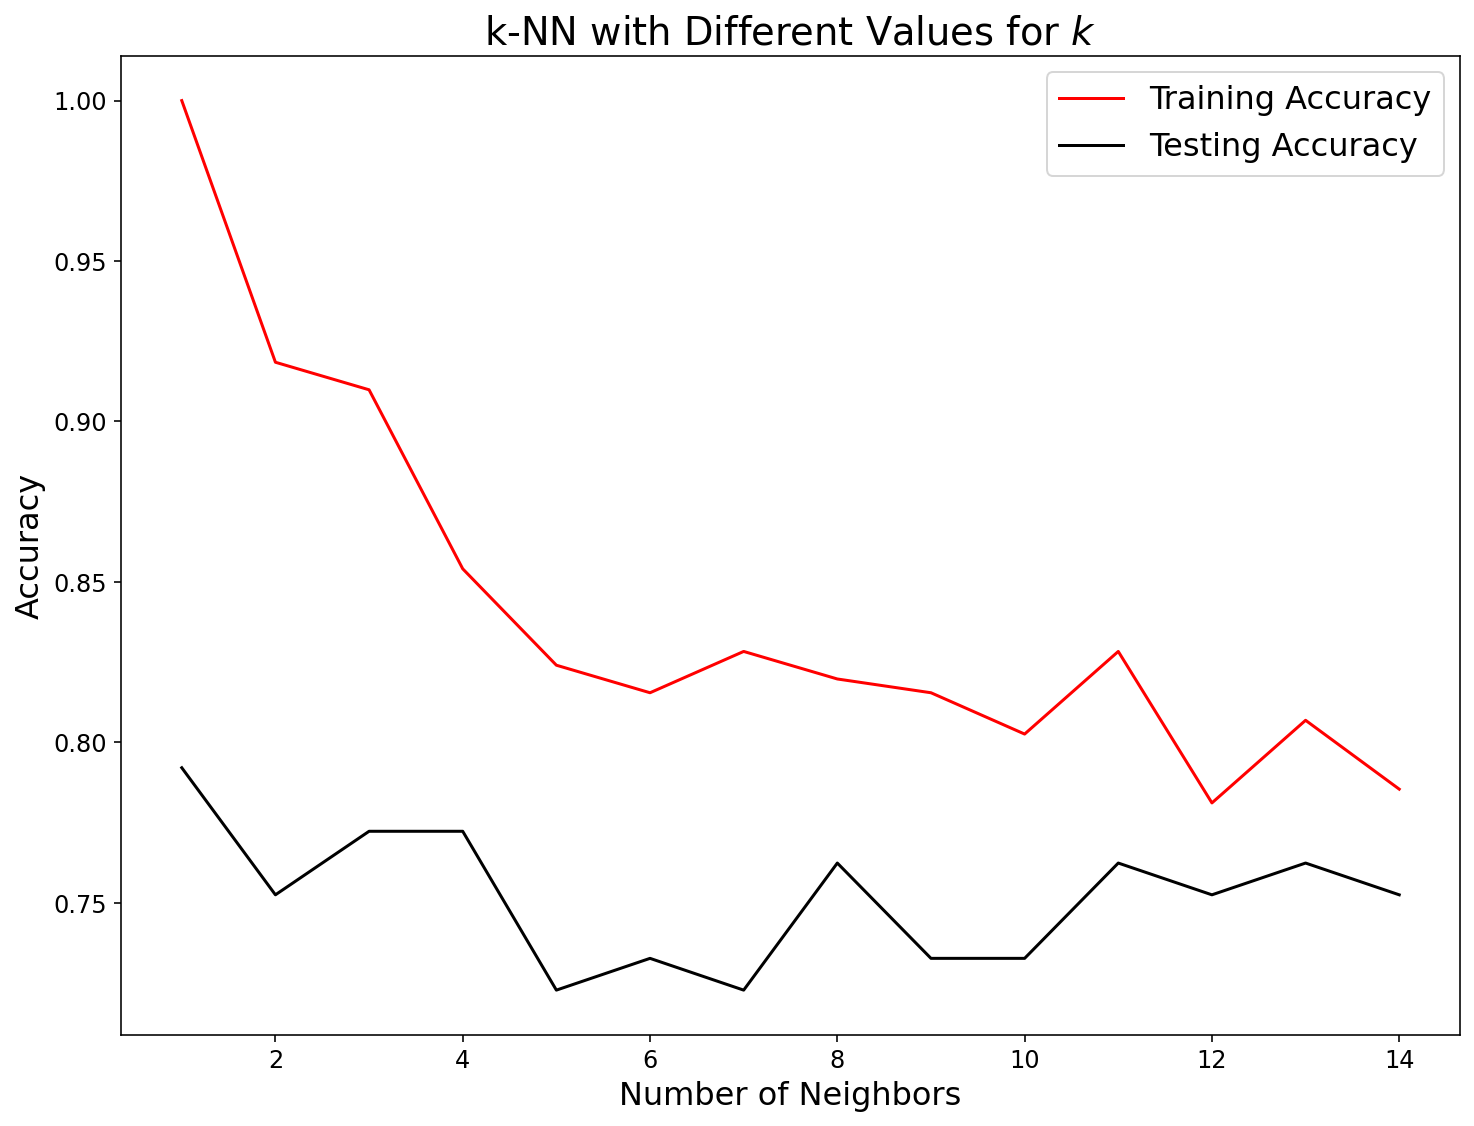

In [237]:
# Create possible values for k
neighbors = np.arange(1, 15)

# Create features and target
X = penguins.select_dtypes(exclude=['object'])
y = penguins.species

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

plot_complexity_curve(neighbors, KNeighborsClassifier, X_train, X_test, y_train, y_test)

From the plot, we can see that either 3 or 4 neighbors is the sweet middle between overfit (very high training score and low test score) and underfit (both training and test scores are low). 

Now, it is time for the regressor:

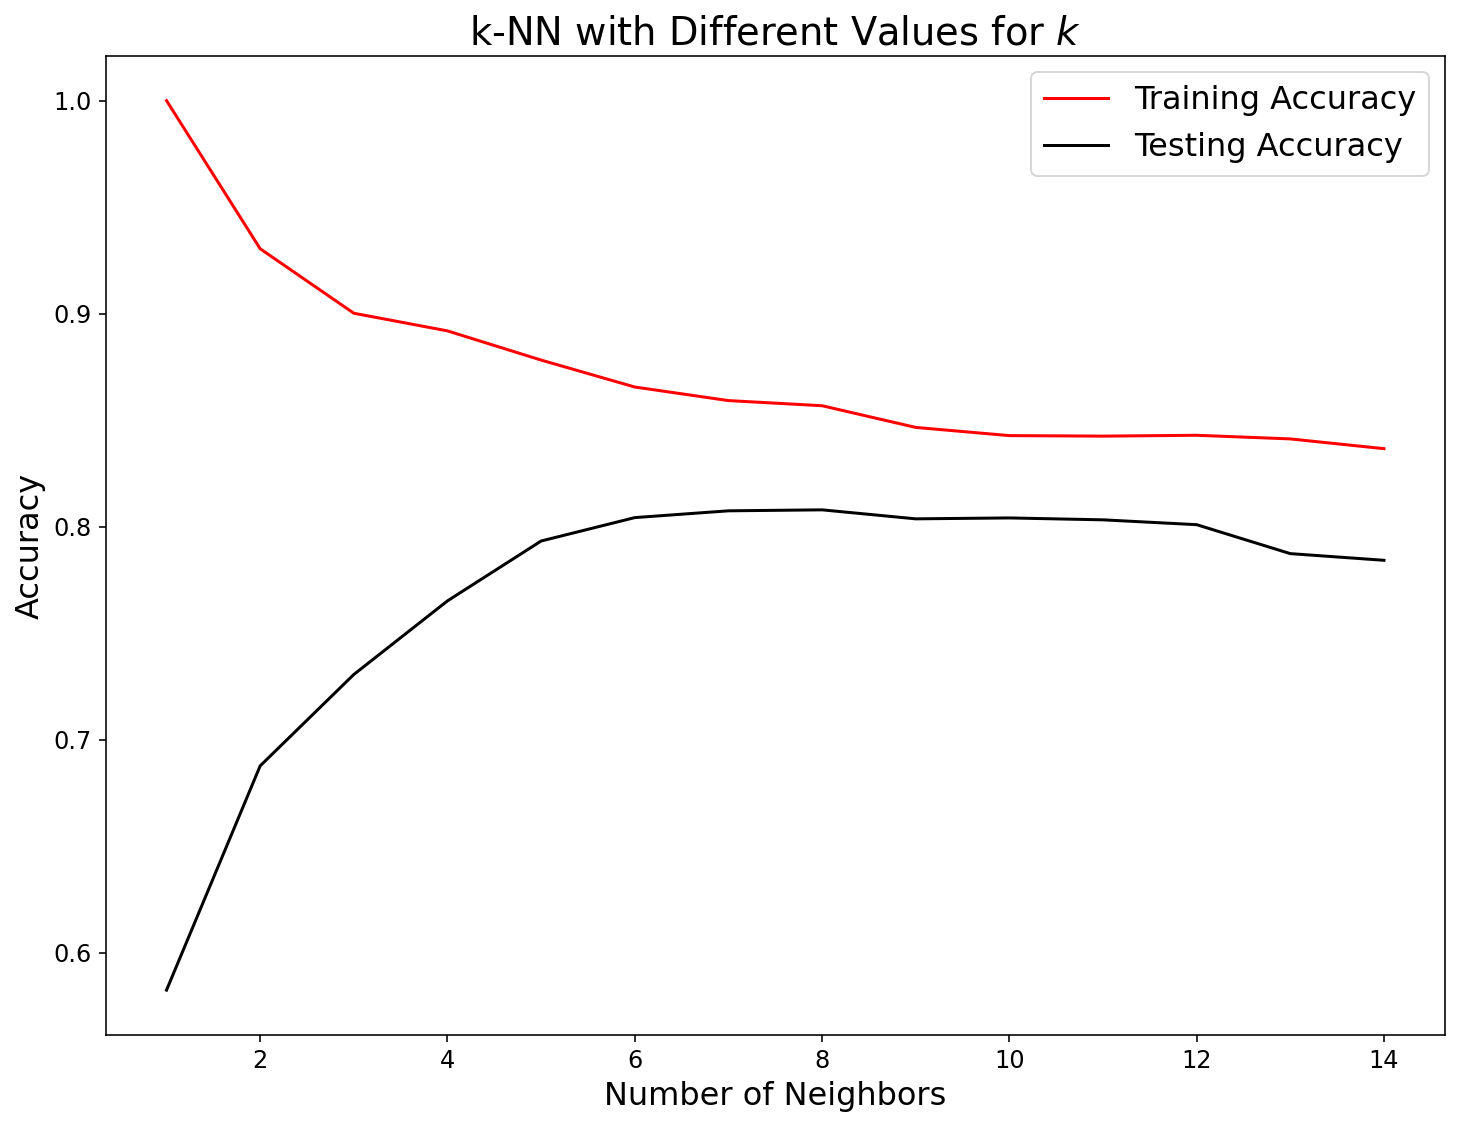

In [238]:
# Create features and target
X = penguins.select_dtypes(exclude=['object']).drop('body_mass_g', axis=1)
y = penguins.body_mass_g

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

plot_complexity_curve(neighbors, KNeighborsRegressor, X_train, X_test, y_train, y_test)

For regressor, it seems that any number of neighbors between 6 and 10 is a good hyperparameter. Note that the accuracy is given as coefficient of determination - $R^2$. Read more about it on sklearn's [official docs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.score).

In both cases, there is a lot of room for improvement. There are a few preprocessing techniques which can drastically improve the performance of kNN. Let's dive into them in the next section!

### Improving the Performance of kNN, Feature Scaling

Even though we got reasonably good scores for penguins dataset, kNN is a very fussy algorithm. It has certain data quality requirements for it to work properly.

The first requirement of kNN is that numerical features should have the same scale. If you pay attention, Body Mass Index column is at a very different scale than all other body measurements. Generally, all features should be scaled so that they range from 0 to 1. 

This can be done using a method called MinMax scaling (called normalization). It subtracts the minimum value and divides by (max - min) for each data point in the distribution:

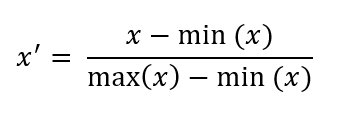

Scikit-Learn conveniently provides a `MinMaxScaler` transformer which performs this normalization to numerical columns in a pandas DataFrame:

In [239]:
from sklearn.preprocessing import MinMaxScaler

Let's apply scaling to all numeric features in penguins. The general syntax is as follows:

In [240]:
# Taken from the sklearn documentation
data = pd.DataFrame([[-1, 2], [-0.5, 6], [0, 10], [1, 18]])
data

,0,1
0,-1.0,2
1,-0.5,6
2,0.0,10
3,1.0,18


In [241]:
scaler = MinMaxScaler()
scaler.fit_transform(data)

array([[0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [1.  , 1.  ]])

After initiating the scaler with `MinMaxScaler`, we call the `fit_transform` method which returns transformed data:

In [262]:
# Build up features and target
X = penguins.select_dtypes(exclude=['object'])
y = penguins.species

# Initiate the scaler
scaler = MinMaxScaler()

# Fit/transform to all numeric data
X_prepped = scaler.fit_transform(X)

# Create new train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_prepped, y, test_size=.3, random_state=4)

We will use our good-ol' `plot_complexity_curve` function to find the best value of *k*:

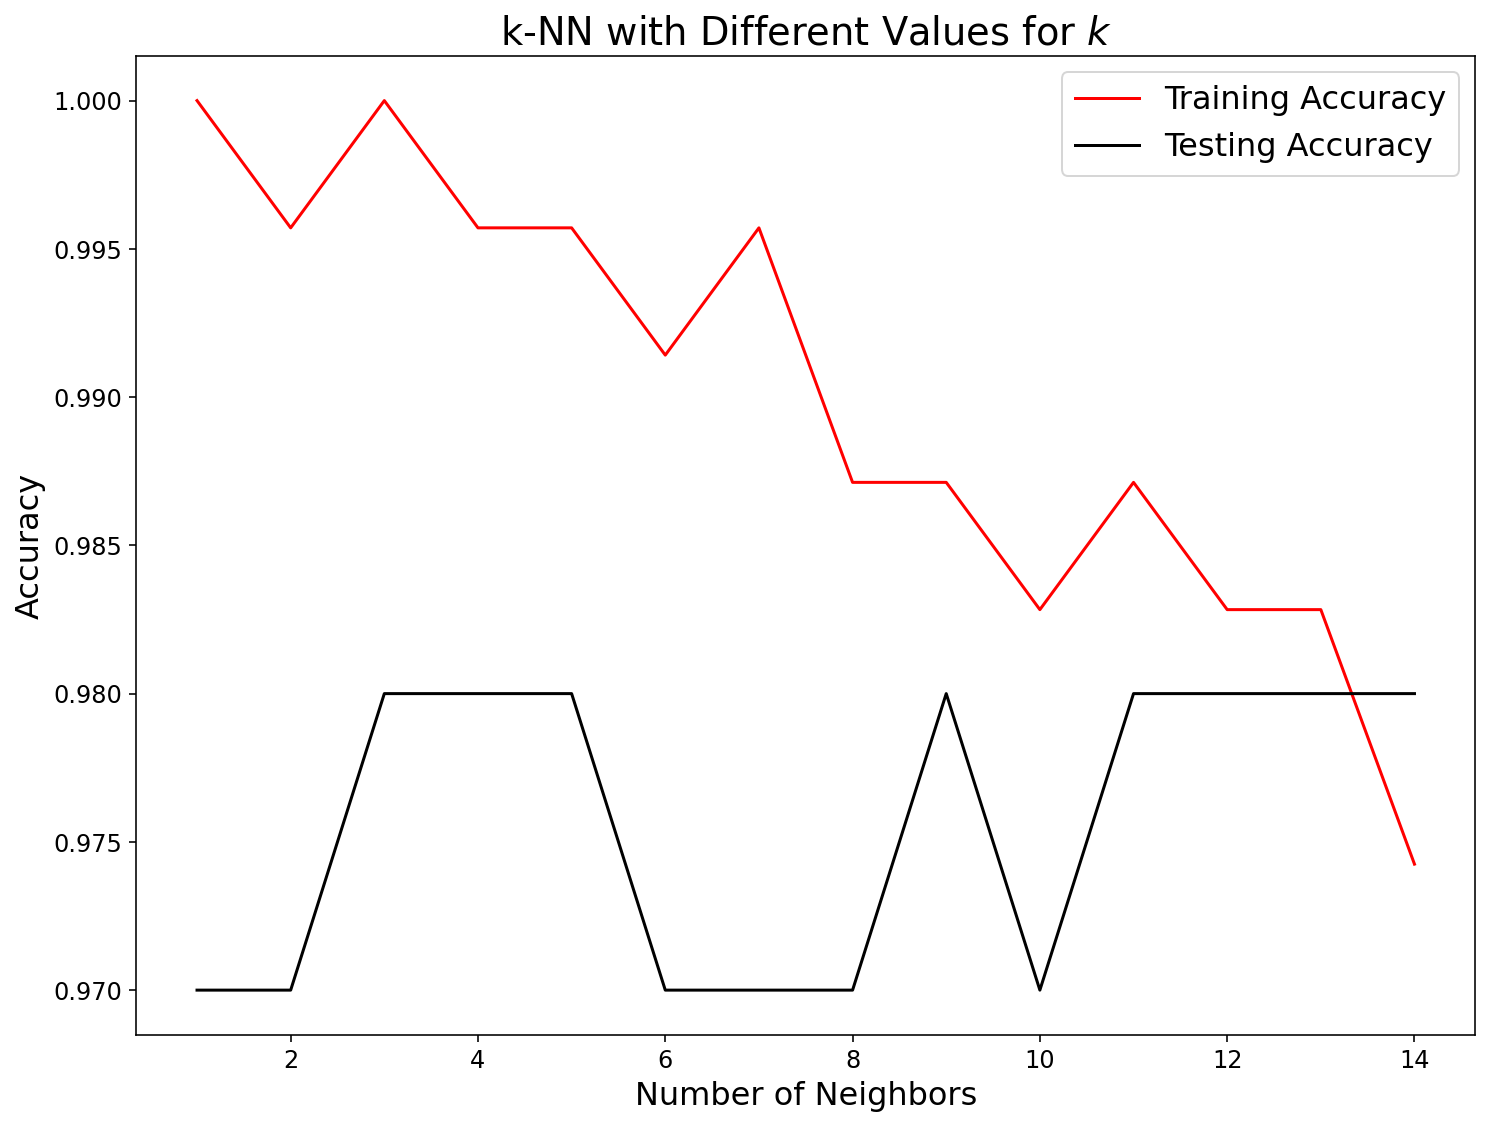

In [263]:
k_list = np.arange(1, 15)

plot_complexity_curve(k_list, KNeighborsClassifier, X_train, X_test, y_train, y_test)

Wow, now all scores are higher than 95%. Look how much feature scaling improved the performance. Looking at the graph, the value for *k* that keeps the balance between underfit and overfit is 12 or 13.

Note that `MinMaxScaler` is not the only option for feature scaling. In cases of outliers, don't use `MinMaxScaler`. Instead, use `StandardScaler` which scales by subtracting the mean and dividing by the standard deviation. See the [user guide](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler) of sklearn for a more detailed guide.

### Encoding Categorical Variables

Even though we almost reasonably good scores, we haven't included the categorical variables into the mix. It is time we bring them in.

Most ML algorithms prefer numeric values, so we should convert all text/categorical variables to numbers. 

> With most datasets, there will be much more problems related to text/categorical values before you convert them to numbers. We will only focus on the conversion part here, but you can check out my definitive guide on cleaning text data using pandas [here](https://towardsdatascience.com/master-the-most-hated-task-in-ds-ml-3b9779276d7c#64a4):

https://towardsdatascience.com/master-the-most-hated-task-in-ds-ml-3b9779276d7c#64a4

Most popular options for encoding categorical values with numbers is sklearn's `OneHotEncoder` and `LabelEncoder`.

Label encoder assigns a new integer to each unique category in the dataset. For example, the island variable has 3 unique categories:

In [243]:
penguins.island.unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

2 categories for sex:

In [244]:
penguins['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

Uh-oh, we have an inconsistent category -  a dot. We should remove it:

In [245]:
penguins.drop(penguins[penguins['sex'] == '.'].index, inplace=True)

assert '.' not in penguins['sex']

Label encoder works best for ordinal variables - categories with order. Even though we don't have an ordering of categories in the dataset, we can still use it.

Before we do the encoding, let's build up the features and target arrays. Remember this time, we are taking all columns as features:

In [246]:
# Build up feature and target
X = penguins.drop('species', axis=1)
y = penguins.species

Now, we should extract categorical and numerical features to separate arrays because we apply different transformers to them:

In [247]:
# Select and extract categorical cols
categorical_cols = X.select_dtypes(include='object').columns
X_cat = X[categorical_cols]

# Select and extract numerical cols
numerical_cols = X.select_dtypes(include='number').columns
X_num = X[numerical_cols]

Like before, let's feature scale numerical features:

In [248]:
# Scale numeric features
scaler = MinMaxScaler()

X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num))

# Scaler removes the column names, so put them back
X_num_scaled.columns = X_num.columns
X_num_scaled.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,0.254545,0.666667,0.152542,0.291667
1,0.269091,0.511905,0.237288,0.305556
2,0.298182,0.583333,0.389831,0.152778
3,0.167273,0.738095,0.355932,0.208333
4,0.261818,0.892857,0.305085,0.263889


As an additional step, we took the scaled array of features and put them back into a DataFrame with their column names. 

Finally, we encode the categorical values:

In [249]:
from sklearn.preprocessing import LabelEncoder

l_encoder = LabelEncoder()

`LabelEncoder` does not work like `MinMaxScaler`. We can't apply it to all categorical columns at the same time. So, we loop over them:

In [250]:
for cat_col in X_cat.columns:
    # Apply the encoder
    X_cat[cat_col] = l_encoder.fit_transform(X_cat[cat_col])

Now, our features data is separated into to preprocessed DataFrames, `X_cat` and `X_num_scaled`:

In [251]:
X_cat.head()

,island,sex
0,2,1
1,2,0
2,2,0
4,2,0
5,2,1


In [252]:
X_num_scaled.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,0.254545,0.666667,0.152542,0.291667
1,0.269091,0.511905,0.237288,0.305556
2,0.298182,0.583333,0.389831,0.152778
3,0.167273,0.738095,0.355932,0.208333
4,0.261818,0.892857,0.305085,0.263889


Let's append them together into a single DataFrame:

In [255]:
X_ready = pd.concat([X_num_scaled, X_cat], axis=1)
X_ready.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island,sex
0,0.254545,0.666667,0.152542,0.291667,2.0,1.0
1,0.269091,0.511905,0.237288,0.305556,2.0,0.0
2,0.298182,0.583333,0.389831,0.152778,2.0,0.0
3,0.167273,0.738095,0.355932,0.208333,NaN,NaN
4,0.261818,0.892857,0.305085,0.263889,2.0,0.0


The transformations introduced some new null values. We should drop those rows from both features and target arrays:

In [257]:
X_ready = X_ready.dropna()
y = y.drop(y[~y.index.isin(X_ready.dropna().index)].index)

Now, we will use the previous `plot_complexity_curve` function to find the best model to predict penguin species:

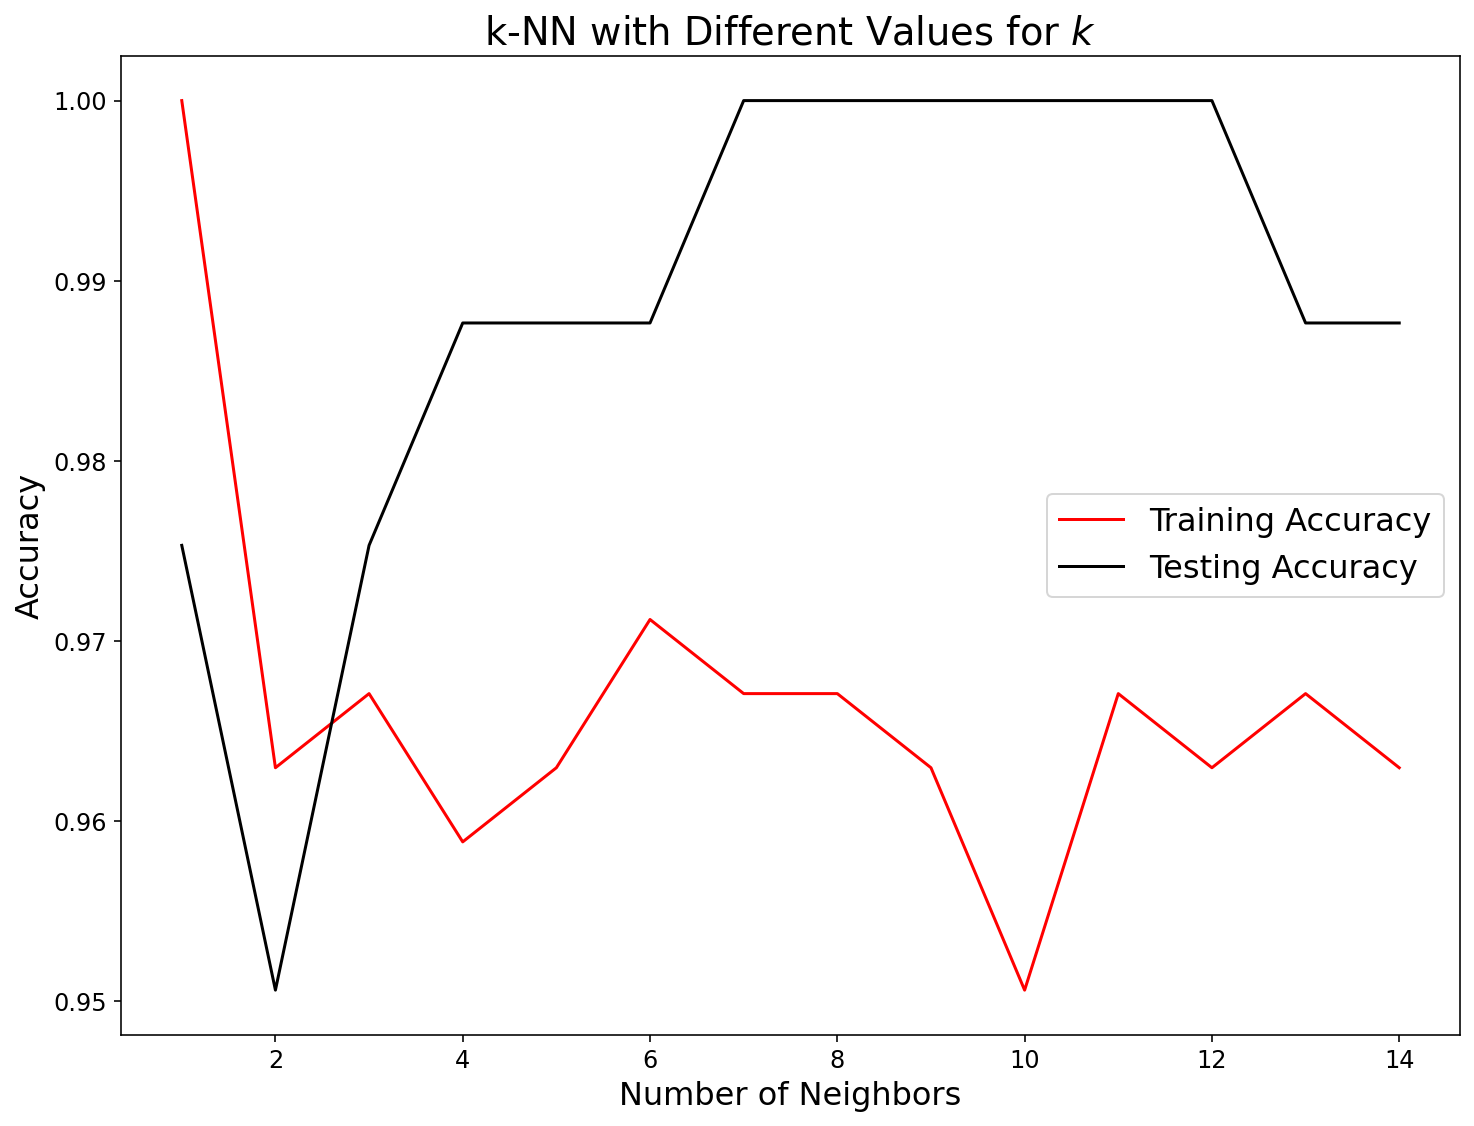

In [261]:
k_list = np.arange(1, 15)

X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=.25, random_state=4)

plot_complexity_curve(k_list, KNeighborsClassifier, X_train, X_test, y_train, y_test)

What? Our testing score is higher than training's? How can this be? There is definitely something fishy going on here. Let's dive deeper in the next section:

### Stratified Splits

This strange event happened after we included categorical values as features. In statistics, there is a term called *sampling bias*. It occurs when your sample is not representative of your true population. 

For example, let's imagine you are doing a nation-wide survey. Obviously, you can't send out questionnaires to everyone in the country, so you take a sample. In the country, there are 54% females and 46% males. To not introduce *sampling bias*, you have to respect this ratio of gender. If you sample 10000 people, you have to make sure that 4600 of them are male and 5400 of them are male. 

Let's investigate what happens when we do a vanilla train/test split. More specifically, we will look if the proportion of categories in island and sex will be preserved:

In [272]:
X = penguins.drop('species', axis=1)
y = penguins.species

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

Look at the proportions of sex in the full data:

In [273]:
X['sex'].value_counts(normalize=True)

MALE      0.504505
FEMALE    0.495495
Name: sex, dtype: float64

Look at the proportions of sex in the training data:

In [274]:
X_train['sex'].value_counts(normalize=True)

FEMALE    0.51073
MALE      0.48927
Name: sex, dtype: float64

Look at the proportions in the test data:

In [276]:
X_test['sex'].value_counts(normalize=True)

MALE      0.54
FEMALE    0.46
Name: sex, dtype: float64

As you can see, we get very different proportions for the test set. Let's try the same for island:

In [278]:
for data in [X, X_train, X_test]:
    print(data['island'].value_counts(normalize=True), '\n')

Biscoe       0.489489
Dream        0.369369
Torgersen    0.141141
Name: island, dtype: float64
Biscoe       0.484979
Dream        0.373391
Torgersen    0.141631
Name: island, dtype: float64
Biscoe       0.50
Dream        0.36
Torgersen    0.14
Name: island, dtype: float64


The same happened for island. Preventing this is very easy with Scikit-learn. `train_test_split` function has a `stratify` parameter which does exactly that: preserve the underlying proportions of categories:

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4, stratify=y)

We always pass `y`(target) to `stratify` in the case of classification. Because, we don't really care about preserving the distribution of features but the target array. Let's use the `plot_complexity_curve` function, now with a stratified split. Before we do the split, we will repeat the last steps of feature scaling and encoding. I won't provide the code again, so assume that `X_ready` and `y` are now preprocessed arrays:

In [283]:
# Build up feature and target
X = penguins.drop('species', axis=1)
y = penguins.species

# Select and extract categorical cols
categorical_cols = X.select_dtypes(include='object').columns
X_cat = X[categorical_cols]

# Select and extract numerical cols
numerical_cols = X.select_dtypes(include='number').columns
X_num = X[numerical_cols]

# Scale numeric features
scaler = MinMaxScaler()

X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num))

# Scaler removes the column names, so put them back
X_num_scaled.columns = X_num.columns

l_encoder = LabelEncoder()

for cat_col in X_cat.columns:
    # Apply the encoder
    X_cat[cat_col] = l_encoder.fit_transform(X_cat[cat_col])
    
X_ready = pd.concat([X_num_scaled, X_cat], axis=1)

X_ready = X_ready.dropna()
y = y.drop(y[~y.index.isin(X_ready.dropna().index)].index)

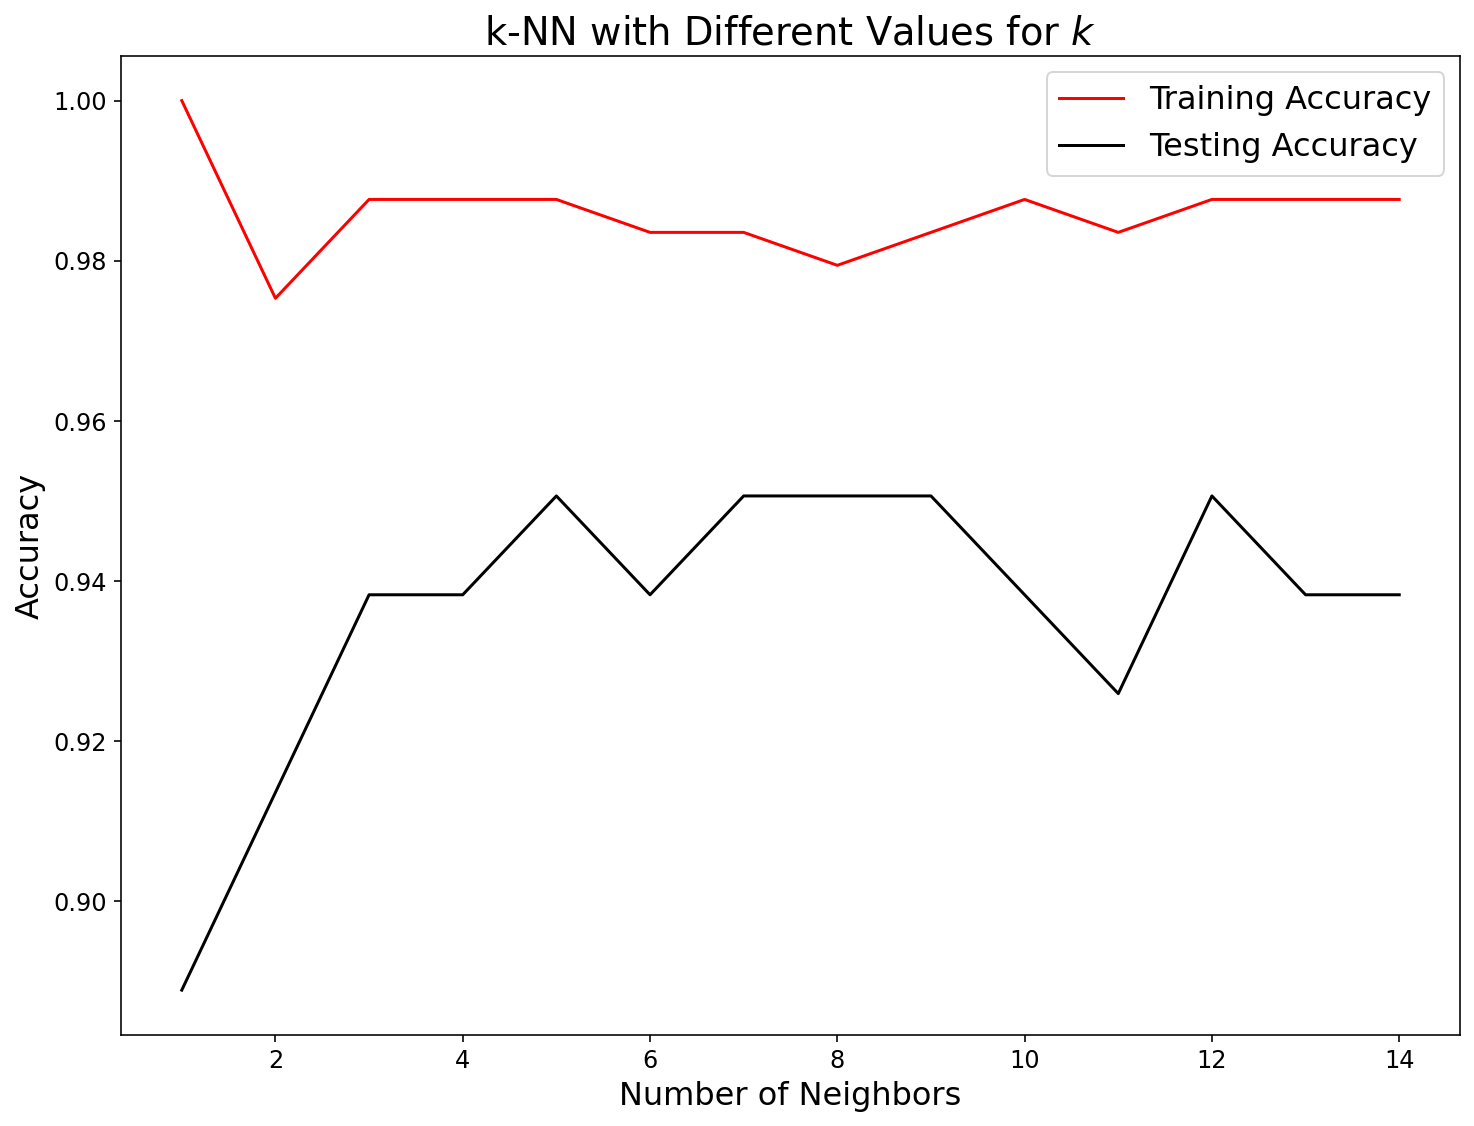

In [284]:
k_list = np.arange(1, 15)

X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=.25, random_state=4, stratify=y)

plot_complexity_curve(k_list, KNeighborsClassifier, X_train, X_test, y_train, y_test)

Now everything is looking as expected. All training scores are higher than training scores. Interpreting the graph, the best value for *k* would be either 7, 8 or 9.

Previously, our split probably generated a more agreeable test set for the model. That's why we got those weird scores.

### Concluding Remarks

I want to finish the article by summarizing the pros and cons of kNN. 

Pros:
- Very simple algorithm, easy to interpret
- Fast training phase
- No assumption of the underlying distribution of data
- Versatile - can be used both for regression and classification

Cons:
- Very slow predicting phase
- Heavy memory usage because it stores all data 
- Sensitive to magnitudes - that's why need features need to be scaled
- Sensitive to outliers and noise
- Suffers from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)